- データから次の着手を予測するDLの構築
- Kerasの紹介
- CNNの理解
- 盤面のベクトル表現
- 新たな活性化関数，ソフトマックス，整流線型ユニット(ReLU)

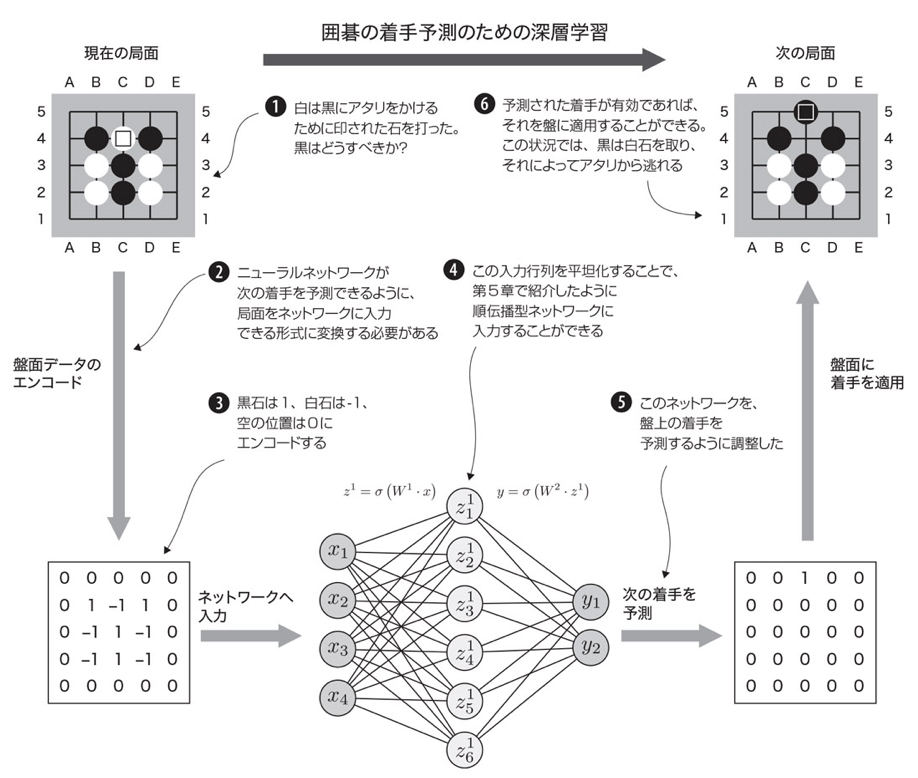

## NNのための局面エンコーディング
局面をNNで扱える表現にするためのエンコーダと元の局面に戻すデコーダを実装

dlgo/encodersに\_\_init\_\_.pyとbase.pyを作成  
base.pyにインタフェースとしてのEncoderクラスを作成  
- Encoder
    - name: ログ，保存
    - encode: 盤面->数値データ
    - encode_point: 盤上の点->整数インデックス
    - decode_point_index: 整数インデックス->盤上の点
    - num_points: 盤上の点の数(盤の幅\*高さ)
    - shape: エンコードされた盤面の構造の形状

base.pyに名前でエンコーダを作成できる関数get_encoder_by_nameを作成  

とりあえず黒は1,白は-1，無いところは0に盤面をエンコードするエンコーダを作る
dlgo/encoders/oneplane.pyを作成し，OnePlaneEncoderを作成  
oneplaneモジュールからOnePlaneEncoderを作成するcreate関数も作成  
内容は，先ほどのインタフェースを実装するようにする

## 木探索によるネットワークの訓練データの生成
ここではMCTSを使って自分自身でゲーム記録を生成してみる  
MCTSエージェントでゲームを進めつつエンコードするgenerate_game関数を定義  
実際にゲームデータを作成するmain関数も定義  
  
goboard_fastを動かすため
- utils.pyにMoveAgeクラスを追加
- [scoring.py](https://raw.githubusercontent.com/maxpumperla/deep_learning_and_the_game_of_go/master/code/dlgo/scoring.py)を作成
- goboard_fastのimportのコメントアウトされているところを外す
- generate_zobrist.pyのstateのループにNoneを追加して再生成  
    - python generate_zobrist.py > zobrist.py

In [1]:
import numpy as np
from IPython.display import clear_output
from dlgo.encoders.base import get_encoder_by_name
from dlgo import goboard_fast as goboard
from dlgo.mcts.mcts import MCTSAgent

In [2]:
def generate_game(board_size, rounds, max_moves, temperature):
    """ MCTSエージェントによる対局データを生成 """
    boards = []
    moves = []
    encoder = get_encoder_by_name('oneplane', board_size)
    game = goboard.GameState.new_game(board_size)
    bot = MCTSAgent(rounds, temperature)
    num_moves = 0

    # 普通にゲームを進めつつ，盤の状況と着手をエンコードしていく
    while not game.is_over():
        move = bot.select_move(game)
        if move.is_play:
            boards.append(encoder.encode(game))
            move_one_hot = np.zeros(encoder.num_points())
            move_one_hot[encoder.encode_point(move.point)] = 1
            moves.append(move_one_hot)
        
        game = game.apply_move(move)

        # ゲーム終了までの着手数制限を設ける
        num_moves += 1
        if num_moves > max_moves:
            break

    return np.array(boards), np.array(moves)

In [4]:
BOARD_SIZE = 9
ROUNDS = 10 # 1000
TEMPERATURE = 0.8
MAX_MOVES = 60
NUM_GAMES = 20
BOARD_OUT = "../datasets/dlgo/features-20.npy"
MOVE_OUT = "../datasets/dlgo/labels-20.npy"

Xs = []
ys = []

for i in range(NUM_GAMES):
    clear_output()
    print(f"Generating game {i+1} / {NUM_GAMES}")
    X, y = generate_game(BOARD_SIZE, ROUNDS, MAX_MOVES, TEMPERATURE)
    Xs.append(X)
    ys.append(y)

# numpyデータとして保存するためにリストを結合
X = np.concatenate(Xs)
y = np.concatenate(ys)

np.save(BOARD_OUT, X)
np.save(MOVE_OUT, y)
print("Saved")

Generating game 20 / 20


ちゃんと作ると大変時間がかかるので，データもらってくる  
https://github.com/maxpumperla/deep_learning_and_the_game_of_go/tree/master/code/generated_games  
features-40k.npy, labels-40k.npyは5000MCTSラウンドで数百のゲームに渡る40000の着手を元に生成されたデータである  
これらを../datasets/dlgoに保存

## 深層学習ライブラリKeras
前章で書いたような低レベルのNNに関する処理はライブラリに任せたい  
本書では，2015年に設立された深層学習ツールKerasを用いる  
Kerasの強み
- APIが直感的で使いやすく，プロトタイピングと実験サイクルが高速  
- 拡張性が高く，新しいカスタムレイヤーの追加などがしやすい
- 一般的なデータセットを直接読み込み可能
  
Kerasはバックエンドという概念を持つのが特徴  
Keras自身は深層学習のフロントエンドとなり，そのバックエンドとしてTensorFlow, Theano, MicrosoftCognitiveToolkitを選べる  

インストール
``` bash
$ pip install tensorflow keras
```
GPUを使うのにtensorflow-gpuというものも必要だが，これはCUDAのバージョンによってインストールするバージョンを変える必要がある模様

あと学校のGPU使うときは[ここ](https://blog.amedama.jp/entry/2017/06/07/220723)に書いてあるように必要な分だけのメモリを確保するようにしよう